# Classical geostatistics (geosclassic wrapper) - examples 1D with non-stationary covariance model

Examples of estimation and simulation for a continuous variable in a 1D grid, based on simple and ordinary kriging, and with a non-stationary covariance model are proposed.

**Remark:** for details explanations about estimation and simulation, see jupyter notebook `ex_geosclassic_1d.ipynb`.

## Import what is required

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# import package 'geone'
import geone as gn

In [2]:
# Show version of python and version of geone
import sys 
print(sys.version_info)
print('geone version: ' + gn.__version__)

sys.version_info(major=3, minor=8, micro=13, releaselevel='final', serial=0)
geone version: 1.1.1


### Remark
The matplotlib figures can be visualized in *interactive* mode:
- `%matplotlib notebook`: enable interactive mode
- `%matplotlib inline`: disable interactive mode

## Launching simulation and estimation in 1D
The following functions are used:
- `geone.geosclassicinterface.simulate1D` for simulation 1D (sequential Gaussian simulation, SGS),
- `geone.geosclassicinterface.estimate1D` for estimation 1D (kriging estimates and standard deviation).

**Alternatives**

The function `geone.multiGaussian.multiGaussianRun` can be used as a wrapper; with keyword arguments  
- `mode='simulation', algo='classic'`: wrapper for `geone.geosclassicinterface.simulate<d>D`,
- `mode='estimation', algo='classic'`: wrapper for `geone.geosclassicinterface.estimate<d>D`,

where the dimension `<d>` is automatically detected.

See jupyter notebook `ex_geosclassic_1d.ipynb` for details.

## Simulation grid
The grid should be defined before defining the non-stationary covariance model.

In [3]:
nx = 1000 # number of cells
dx = 0.5  # cell unit
ox = 0.0  # origin

## Define a non-stationary covariance model in 1D: class `geone.covModel.covModel1D`

A covariance model is defined by its elementary contributions given as a list of 2-tuples, 
whose the first component is the type given by a string (`nugget`, `spherical`, `exponential`, `gaussian`, ...) and the second component is a dictionary used to pass the required parameters (the weight (`w`), the range (`r`), ...).

Those parameters can be set to a `numpy array` with values attached to the simulation grid. Hence, the size of the array and the number of grid cells must match. In this way a non-stationary covariance model can be defined.

**Remark:** some functionalities such as getting the sill, range, or plotting the model are not available for non-stationary covariance model.

### Example: gaussian model and varying nugget

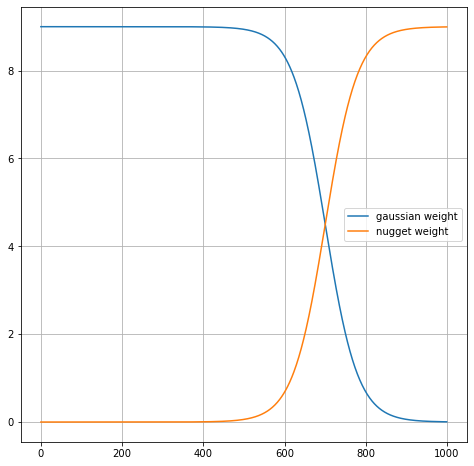

In [4]:
x_grid = ox + np.arange(nx)*dx
nug_w = 9. * 1. / (1. + np.exp(-(x_grid-350)/20)) # set weight over the sim. grid for nugget
gau_w = 9 - nug_w       # set weight over the sim. grid for gaussian covariance contribution


plt.figure(figsize=(8,8))
plt.plot(gau_w, label='gaussian weight')
plt.plot(nug_w, label='nugget weight')
plt.grid()
plt.legend()
plt.show()

In [5]:
# Define the non-stationary covariance model 
cov_model = gn.covModel.CovModel1D(elem=[
    ('gaussian', {'w':gau_w, 'r':100}),  # elementary contribution
    ('nugget', {'w':nug_w, 'r':100}), # elementary contribution
    #('spherical', {'w':sph_w, 'r':100}), # elementary contribution
    ], name='model-1D example')

### Conditional simulations (hard data) (function `geone.geosclassicinterface.simulate1D`)
Define hard data. Note that the conditioning values will be attached to the grid cells containing the corresponding conditioning locations.

In [6]:
x = [10.1, 50.7, 238.5, 384.3] # locations (real coordinates)
v = [-3.2,  1.2,   4.7,  -2.0] # values

In [7]:
# Simulation
nreal = 2000
np.random.seed(321)
geosclassic_output = gn.geosclassicinterface.simulate1D(cov_model, nx, dx, ox, 
                                                        x=x, v=v, method='simple_kriging',
                                                        searchRadiusRelative=1.0, nneighborMax=12,
                                                        nreal=nreal)

Geos-Classic running... [VERSION 2.0 / BUILD NUMBER 20220627 / OpenMP 7 thread(s)]
Geos-Classic run complete


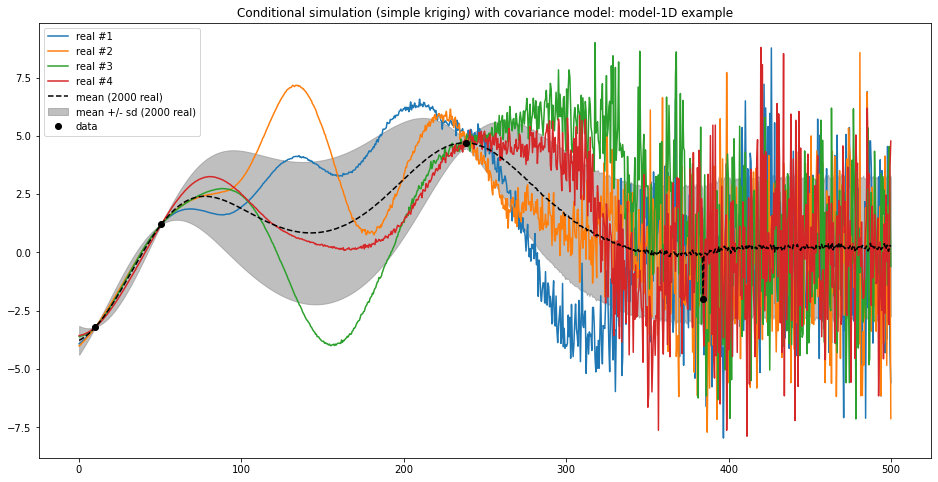

In [8]:
# Retrieve the realizations
simul = geosclassic_output['image'] 
# geosclassic_output['image'] is an image (class geone.img.Img) with nreal variables: 
# i-th variable is the i-th realization

# Compute mean and standard deviation (pixel-wise)
simul_mean = gn.img.imageContStat(simul, op='mean')
simul_std = gn.img.imageContStat(simul, op='std')

# Plot the first realizations, the mean and the mean +/- standard deviation
plt.figure(figsize=(16,8))

for i in range(4):
    plt.plot(simul.x(), simul.val[i,0,0,:], label='real #{}'.format(i+1))

plt.plot(simul_mean.x(), simul_mean.val[0,0,0,:], c='black', ls='dashed', label='mean ({} real)'.format(nreal))
plt.fill_between(simul_mean.x(), 
                 simul_mean.val[0,0,0,:] - simul_std.val[0,0,0,:], 
                 simul_mean.val[0,0,0,:] + simul_std.val[0,0,0,:], 
                 color='gray', alpha=.5, label='mean +/- sd ({} real)'.format(nreal))

plt.plot(x, v, 'o', c='k', label='data') # add conditioning points

plt.legend()
plt.title('Conditional simulation (simple kriging) with covariance model: {}'.format(cov_model.name))

plt.show()

### Estimation: kriging estimates and standard deviation
#### Function `geone.geosclassicinterface.estimate1D`
*Note:* unique search neighorhood can not be used with a non-stationary covariance model.

In [9]:
# Increase searchRadiusRelative to avoid "discontinuities"
geosclassic_output = gn.geosclassicinterface.estimate1D(cov_model, nx, dx, ox, 
                                                        x=x, v=v, method='simple_kriging', 
                                                        searchRadiusRelative=2.0)

Geos-Classic running... [VERSION 2.0 / BUILD NUMBER 20220627 / OpenMP 7 thread(s)]
Geos-Classic run complete


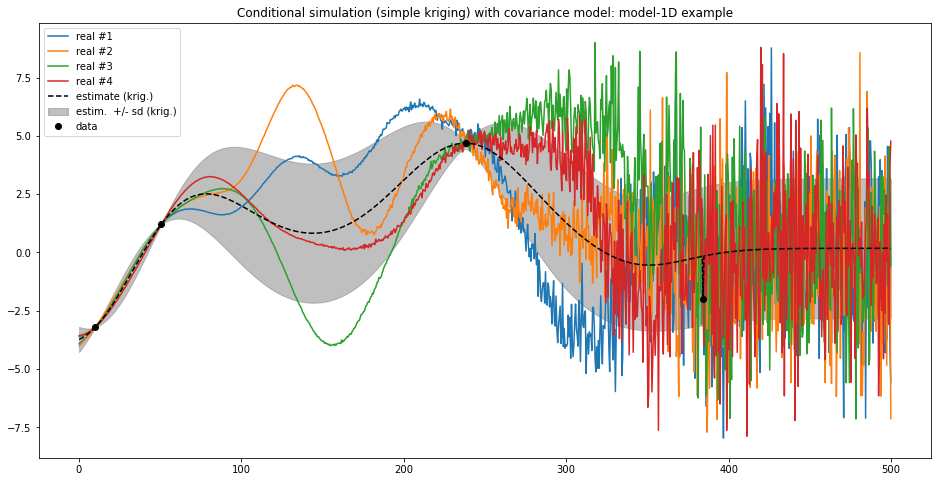

In [10]:
# Retrieve the results of estimation
estim = geosclassic_output['image']
# geosclassic_output['image'] is an image (class geone.img.Img) with 2 variables: 
# kriging estimates and kriging st. dev.


# Plot the first realizations of the previous simulation and the results of estimation.
plt.figure(figsize=(16,8))

for i in range(4):
    plt.plot(simul.x(), simul.val[i,0,0,:], label='real #{}'.format(i+1))

plt.plot(estim.x(), estim.val[0,0,0,:], c='black', ls='dashed', label='estimate (krig.)')
plt.fill_between(estim.x(), 
                 estim.val[0,0,0,:] - estim.val[1,0,0,:], 
                 estim.val[0,0,0,:] + estim.val[1,0,0,:], 
                 color='gray', alpha=.5, label='estim.  +/- sd (krig.)')

plt.plot(x, v, 'o', c='k', label='data') # add conditioning points

plt.legend()
plt.title('Conditional simulation (simple kriging) with covariance model: {}'.format(cov_model.name))

plt.show()

## Conditioning with inequality data (simulation only)

Simulation can be done with usual hard data and inequality data consisting in a lower and/or upper bound at some points.

The conditioning locations with inequality data are first simulated (with truncated gaussian distribution) sequentially. Then, these locations are re-simulated following a new path as many times as needed (Gibbs sampler); the total number of paths will be between `nGibbsSamplerPathMin` and `nGibbsSamplerPathMax` (keyword arguments, default: 50 and 200 respectively).

Define hard data and inequality data with minimal value and inequality with maximal value. Note that the conditioning values (hard, min. or max.) will be attached to the grid cells containing the corresponding conditioning locations.

In [11]:
# Hard data
x = [10.1, 50.7, 238.5, 384.3] # locations (real coordinates)
v = [-3.2,  1.2,   4.7,  -2.0] # values
#x = [10.25, 50.75, 238.25, 384.25] # locations (real coordinates)
#v = [-3.2 ,  1.2 ,    4.7,  -2.0 ] # values

# Inequality data
xIneqMin = [185.75, 288.25] # locations (real coordinates)
vIneqMin = [  6.2 ,  -3.8]  # lower bounds

xIneqMax = [100.25, 288.25] # locations (real coordinates)
vIneqMax = [ -4.1 ,  -3.2]  # upper bounds
# Note: second inequality data point has a lower bound and an upper bound

In [12]:
# Simulation
nreal = 2000
np.random.seed(321)
geosclassic_output = gn.geosclassicinterface.simulate1D(cov_model, nx, dx, ox, 
                                                        x=x, v=v, 
                                                        xIneqMin=xIneqMin, vIneqMin=vIneqMin,
                                                        xIneqMax=xIneqMax, vIneqMax=vIneqMax,
                                                        searchRadiusRelative=3.,
                                                        method='simple_kriging', nreal=nreal)

Geos-Classic running... [VERSION 2.0 / BUILD NUMBER 20220627 / OpenMP 7 thread(s)]
Geos-Classic run complete


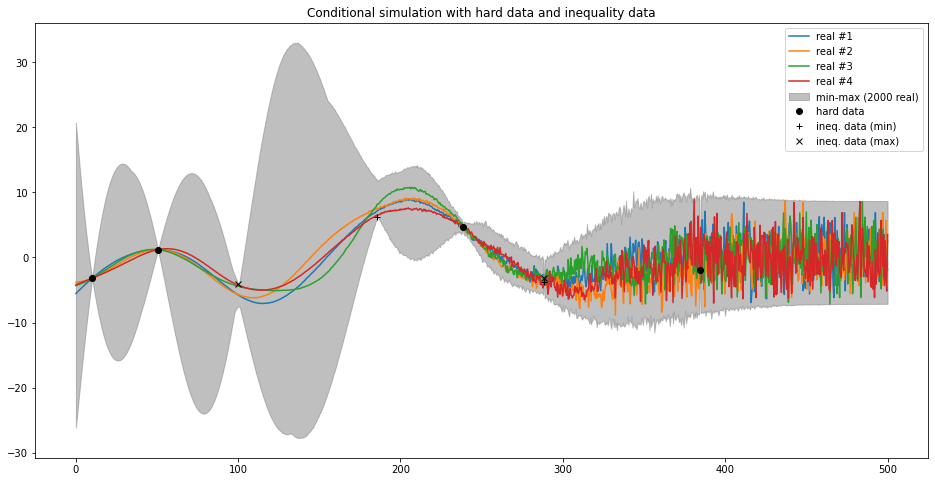

In [13]:
# Retrieve the realizations
simul = geosclassic_output['image']

# Compute min and max (pixel-wise)
simul_min = gn.img.imageContStat(simul, op='min')
simul_max = gn.img.imageContStat(simul, op='max')

# Plot the first realizations, the min-max interval
plt.figure(figsize=(16,8))

for i in range(4):
    plt.plot(simul.x(), simul.val[i,0,0,:], label='real #{}'.format(i+1))

plt.fill_between(simul.x(), simul_min.val[0,0,0,:], simul_max.val[0,0,0,:], 
                 color='gray', alpha=.5, label='min-max ({} real)'.format(nreal))

plt.plot(x, v, 'o', c='k', label='hard data') # add hard data
plt.plot(xIneqMin, vIneqMin, '+', c='k', label='ineq. data (min)') # add inequality data with min. value
plt.plot(xIneqMax, vIneqMax, 'x', c='k', label='ineq. data (max)') # add inequality data with max. value

plt.legend()
plt.title('Conditional simulation with hard data and inequality data')

plt.show()

### Check that conditioning data are honoured

In [14]:
# Get index of conditioning location in simulation grid
hd_grid_index = [gn.img.pointToGridIndex(xx, 0, 0, dx, 1., 1., ox, 0., 0.) for xx in x]
ineqMin_grid_index = [gn.img.pointToGridIndex(xx, 0, 0, dx, 1., 1., ox, 0., 0.) for xx in xIneqMin]
ineqMax_grid_index = [gn.img.pointToGridIndex(xx, 0, 0, dx, 1., 1., ox, 0., 0.) for xx in xIneqMax]

# Min and max value at hard data
min_value_at_hd = np.asarray([simul_min.val[0][grid_index[::-1]] for grid_index in hd_grid_index])
max_value_at_hd = np.asarray([simul_max.val[0][grid_index[::-1]] for grid_index in hd_grid_index])
print('Hard data value:\n{}'.format(v))
print('Min and max value at hard data:\n{}\n{}'.format(
    min_value_at_hd, max_value_at_hd))
print('Hard data, abs error max: {}\n'.format(max(np.ptp(min_value_at_hd - v), np.ptp(max_value_at_hd - v))))
      
# Min and max value at inequality data with minimal value
min_value_at_ineqMin = np.asarray([simul_min.val[0][grid_index[::-1]] for grid_index in ineqMin_grid_index])
max_value_at_ineqMin = np.asarray([simul_max.val[0][grid_index[::-1]] for grid_index in ineqMin_grid_index])
print('Minimal data value:\n{}'.format(vIneqMin))
print('Min and max value at inequality data with maximal value:\n{}\n{}'.format(
    min_value_at_ineqMin, max_value_at_ineqMin))
print('All min data value honoured ? {}\n'.format(np.all(min_value_at_ineqMin > vIneqMin)))

# Min and max value at inequality data with maximal value
min_value_at_ineqMax = np.asarray([simul_min.val[0][grid_index[::-1]] for grid_index in ineqMax_grid_index])
max_value_at_ineqMax = np.asarray([simul_max.val[0][grid_index[::-1]] for grid_index in ineqMax_grid_index])
print('Maximal data value:\n{}'.format(vIneqMax))
print('Min and max value at inequality data with maximal value:\n{}\n{}'.format(
    min_value_at_ineqMax, max_value_at_ineqMax))
print('All max data value honoured ? {}'.format(np.all(max_value_at_ineqMax < vIneqMax)))

Hard data value:
[-3.2, 1.2, 4.7, -2.0]
Min and max value at hard data:
[-3.2  1.2  4.7 -2. ]
[-3.2  1.2  4.7 -2. ]
Hard data, abs error max: 2.220446049250313e-16

Minimal data value:
[6.2, -3.8]
Min and max value at inequality data with maximal value:
[ 6.21008831 -3.79453219]
[11.77470184 -3.201179  ]
All min data value honoured ? True

Maximal data value:
[-4.1, -3.2]
Min and max value at inequality data with maximal value:
[-7.49574192 -3.79453219]
[-4.10193202 -3.201179  ]
All max data value honoured ? True
